In [1]:
import numpy as np
import random
import torch

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
print("✓ Random seeds initialized for reproducibility")


✓ Random seeds initialized for reproducibility


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None) 
from modules.preprocessing import prepare_columns
from modules.config import TAXI_ZONE_PATH
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os


In [3]:
uber_trips = prepare_columns()

In [4]:
# ============================================================================
# SHARED ACCEPTANCE RATE FUNCTION
# ============================================================================
def calculate_acceptance_rate(predicted_price, actual_fare):
    """
    Calculate acceptance probability based on price difference.
    Uses sigmoid function with configurable threshold.
    
    Args:
        predicted_price: Price quoted to customer
        actual_fare: True/base fare for the ride
    
    Returns:
        float: Acceptance probability [0, 1]
    """
    if actual_fare <= 0:
        return 0.0
    
    price_diff = abs(predicted_price - actual_fare)
    max_acceptable_diff = actual_fare * 0.5  # 50% deviation threshold
    
    # Sigmoid-based acceptance curve
    acceptance_rate = 1.0 / (1.0 + np.exp((price_diff - max_acceptable_diff) / (max_acceptable_diff * 0.1)))
    return np.clip(acceptance_rate, 0.0, 1.0)


# ============================================================================
# TRAIN/TEST SPLIT (BEFORE PROCESSING)
# ============================================================================
print("="*70)
print("TRAIN/TEST SPLIT (ON RAW DATA)")
print("="*70)

data_raw = uber_trips.copy()

train_data_raw, test_data_raw = train_test_split(
    data_raw, 
    test_size=0.2, 
    random_state=42
)

print(f"Original data size: {len(data_raw)}")
print(f"Training data size (raw): {len(train_data_raw)}")
print(f"Testing data size (raw): {len(test_data_raw)}")
print(f"Train/Test Split: 80/20\n")


TRAIN/TEST SPLIT (ON RAW DATA)
Original data size: 10000
Training data size (raw): 8000
Testing data size (raw): 2000
Train/Test Split: 80/20



In [5]:
# ============================================================================
# STATIC PRICING WITH PROBABILISTIC ACCEPTANCE (CALIBRATED ON TRAINING DATA)
# ============================================================================
print("="*70)
print("STATIC PRICING STRATEGY (CALIBRATED ON TRAINING DATA)")
print("="*70)

# STEP 1: Calibrate pricing model on training data
print("\n1. Calibration Phase (using TRAINING data):")
average_price_per_mile = train_data_raw['final_fare'].sum() / train_data_raw['trip_miles'].sum()
print(f"   Calibrated Price Per Mile: ${average_price_per_mile:.2f}")

# STEP 2: Apply static pricing to test data
print("\n2. Testing Phase (applying to TEST data):")
static_per_mile_pricing = test_data_raw.copy()
static_per_mile_pricing['static_price'] = (
    static_per_mile_pricing['trip_miles'] * average_price_per_mile 
    + static_per_mile_pricing["tolls"] 
    + static_per_mile_pricing['bcf'] 
    + static_per_mile_pricing['sales_tax'] 
    + static_per_mile_pricing['congestion_surcharge'] 
    + static_per_mile_pricing["airport_fee"]
)

# STEP 3: Calculate acceptance rates for test data
static_per_mile_pricing['acceptance_rate'] = static_per_mile_pricing.apply(
    lambda row: calculate_acceptance_rate(row['static_price'], row['final_fare']),
    axis=1
)

# STEP 4: Simulate acceptance (using pre-set seed)
static_per_mile_pricing['is_accepted'] = static_per_mile_pricing['acceptance_rate'].apply(
    lambda rate: np.random.rand() < rate
)

static_per_mile_pricing['static_profit'] = static_per_mile_pricing.apply(
    lambda row: row['static_price'] - row['driver_pay'] - row["sales_tax"] if row['is_accepted'] else 0,
    axis=1
)

average_profit_per_ride = static_per_mile_pricing['static_profit'].mean()
average_fare_per_ride = static_per_mile_pricing['static_price'].mean()
static_acceptance_rate = static_per_mile_pricing['is_accepted'].mean()
static_accepted_rides = static_per_mile_pricing['is_accepted'].sum()
static_total_revenue = static_per_mile_pricing[static_per_mile_pricing['is_accepted']]['static_price'].sum()
static_avg_revenue_per_ride = static_total_revenue / len(static_per_mile_pricing)

print("\n" + "="*70)
print("STATIC PRICING PERFORMANCE METRICS")
print("="*70)
print(f"Average Price Per Mile: ${average_price_per_mile:.2f}")
print(f"Average Profit Per Ride: ${average_profit_per_ride:.2f}")
print(f"Average Fare Per Ride: ${average_fare_per_ride:.2f}")
print(f"Average Revenue Per Ride: ${static_avg_revenue_per_ride:.2f}")
print(f"Acceptance Rate: {static_acceptance_rate:.2%}")
print(f"Accepted Rides: {static_accepted_rides} / {len(static_per_mile_pricing)}")
print(f"Total Revenue: ${static_total_revenue:.2f}")

print("\n" + "="*70)
print("PROFIT STATISTICS")
print("="*70)
print(static_per_mile_pricing['static_profit'].describe())

print("\n" + "="*70)
print("PRICE STATISTICS")
print("="*70)
print(static_per_mile_pricing['static_price'].describe())

print("\n" + "="*70)
print("ACCEPTANCE RATE STATISTICS")
print("="*70)
print(static_per_mile_pricing['acceptance_rate'].describe())


STATIC PRICING STRATEGY (CALIBRATED ON TRAINING DATA)

1. Calibration Phase (using TRAINING data):
   Calibrated Price Per Mile: $4.48

2. Testing Phase (applying to TEST data):

STATIC PRICING PERFORMANCE METRICS
Average Price Per Mile: $4.48
Average Profit Per Ride: $3.79
Average Fare Per Ride: $23.46
Average Revenue Per Ride: $16.16
Acceptance Rate: 81.75%
Accepted Rides: 1635 / 2000
Total Revenue: $32315.70

PROFIT STATISTICS
count    2000.000000
mean        3.791124
std         8.857604
min       -22.234491
25%        -0.203554
50%         0.684755
75%         5.459446
max        94.472383
Name: static_profit, dtype: float64

PRICE STATISTICS
count    2000.000000
mean       23.464249
std        21.698368
min         0.948559
25%         9.148656
50%        16.229232
75%        28.914299
max       157.425718
Name: static_price, dtype: float64

ACCEPTANCE RATE STATISTICS
count    2000.000000
mean        0.819896
std         0.326429
min         0.000000
25%         0.847443
50%     

FEATURE ENGINEERING CONFIGURATION
Numerical Features (5): ['trip_miles', 'tips', 'wait', 'day_of_month', 'precip']
Categorical Features (6): ['Pickup_Borough', 'Dropoff_Borough', 'preciptype', 'time_of_day', 'shared_request_flag', 'shared_match_flag']
Target Feature: final_fare

FEATURE ENGINEERING (FIT ON TRAINING DATA)
Fitting and scaling numerical features on training data...
Fitting and one-hot encoding categorical features on training data...

Processed Training Data Shape: (8000, 15)
Processed Testing Data Shape: (2000, 15)
State Size: 14
Action Size: 11

Processed columns:
   1. trip_miles
   2. tips
   3. wait
   4. day_of_month
   5. precip
   6. Pickup_Borough_Brooklyn
   7. Pickup_Borough_Manhattan
   8. Pickup_Borough_Queens
   9. Pickup_Borough_Staten Island
  10. Dropoff_Borough_Brooklyn
  11. Dropoff_Borough_Manhattan
  12. Dropoff_Borough_Queens
  13. Dropoff_Borough_Staten Island
  14. Dropoff_Borough_Unknown
  15. final_fare

CATEGORICAL ENCODING DETAILS
One-hot encod

FEATURE ENGINEERING CONFIGURATION
Numerical Features (5): ['trip_miles', 'tips', 'wait', 'day_of_month', 'precip']
Categorical Features (6): ['Pickup_Borough', 'Dropoff_Borough', 'preciptype', 'time_of_day', 'shared_request_flag', 'shared_match_flag']
Target Feature: final_fare

FEATURE ENGINEERING (FIT ON TRAINING DATA)
Fitting and scaling numerical features on training data...
Fitting and one-hot encoding categorical features on training data...

Processed Training Data Shape: (8000, 15)
Processed Testing Data Shape: (2000, 15)
State Size: 14
Action Size: 11

Processed columns:
   1. trip_miles
   2. tips
   3. wait
   4. day_of_month
   5. precip
   6. Pickup_Borough_Brooklyn
   7. Pickup_Borough_Manhattan
   8. Pickup_Borough_Queens
   9. Pickup_Borough_Staten Island
  10. Dropoff_Borough_Brooklyn
  11. Dropoff_Borough_Manhattan
  12. Dropoff_Borough_Queens
  13. Dropoff_Borough_Staten Island
  14. Dropoff_Borough_Unknown
  15. final_fare

CATEGORICAL ENCODING DETAILS
One-hot encod

/var/folders/j8/2xxj5v895d3gt_n2nn9rwx7r0000gn/T/ipykernel_6176/4147414443.py:155: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_rate = 1.0 / (1.0 + np.exp((price_diff - max_acceptable_diff) / (max_acceptable_diff * 0.1)))


FEATURE ENGINEERING CONFIGURATION
Numerical Features (5): ['trip_miles', 'tips', 'wait', 'day_of_month', 'precip']
Categorical Features (6): ['Pickup_Borough', 'Dropoff_Borough', 'preciptype', 'time_of_day', 'shared_request_flag', 'shared_match_flag']
Target Feature: final_fare

FEATURE ENGINEERING (FIT ON TRAINING DATA)
Fitting and scaling numerical features on training data...
Fitting and one-hot encoding categorical features on training data...

Processed Training Data Shape: (8000, 15)
Processed Testing Data Shape: (2000, 15)
State Size: 14
Action Size: 11

Processed columns:
   1. trip_miles
   2. tips
   3. wait
   4. day_of_month
   5. precip
   6. Pickup_Borough_Brooklyn
   7. Pickup_Borough_Manhattan
   8. Pickup_Borough_Queens
   9. Pickup_Borough_Staten Island
  10. Dropoff_Borough_Brooklyn
  11. Dropoff_Borough_Manhattan
  12. Dropoff_Borough_Queens
  13. Dropoff_Borough_Staten Island
  14. Dropoff_Borough_Unknown
  15. final_fare

CATEGORICAL ENCODING DETAILS
One-hot encod

/var/folders/j8/2xxj5v895d3gt_n2nn9rwx7r0000gn/T/ipykernel_6176/4147414443.py:155: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_rate = 1.0 / (1.0 + np.exp((price_diff - max_acceptable_diff) / (max_acceptable_diff * 0.1)))


Episode  30/100 | Avg Reward:  1.1788 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  40/100 | Avg Reward:  1.1680 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  50/100 | Avg Reward:  1.1792 | Acceptance Rate: 99.00% | Epsilon: 0.0100
Episode  60/100 | Avg Reward:  1.1216 | Acceptance Rate: 99.00% | Epsilon: 0.0100
Episode  70/100 | Avg Reward:  1.1608 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  80/100 | Avg Reward:  1.1432 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  90/100 | Avg Reward:  1.1536 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode 100/100 | Avg Reward:  1.1780 | Acceptance Rate: 100.00% | Epsilon: 0.0100

TRAINING COMPLETED


FEATURE ENGINEERING CONFIGURATION
Numerical Features (5): ['trip_miles', 'tips', 'wait', 'day_of_month', 'precip']
Categorical Features (6): ['Pickup_Borough', 'Dropoff_Borough', 'preciptype', 'time_of_day', 'shared_request_flag', 'shared_match_flag']
Target Feature: final_fare

FEATURE ENGINEERING (FIT ON TRAINING DATA)
Fitting and scaling numerical features on training data...
Fitting and one-hot encoding categorical features on training data...

Processed Training Data Shape: (8000, 15)
Processed Testing Data Shape: (2000, 15)
State Size: 14
Action Size: 11

Processed columns:
   1. trip_miles
   2. tips
   3. wait
   4. day_of_month
   5. precip
   6. Pickup_Borough_Brooklyn
   7. Pickup_Borough_Manhattan
   8. Pickup_Borough_Queens
   9. Pickup_Borough_Staten Island
  10. Dropoff_Borough_Brooklyn
  11. Dropoff_Borough_Manhattan
  12. Dropoff_Borough_Queens
  13. Dropoff_Borough_Staten Island
  14. Dropoff_Borough_Unknown
  15. final_fare

CATEGORICAL ENCODING DETAILS
One-hot encod

/var/folders/j8/2xxj5v895d3gt_n2nn9rwx7r0000gn/T/ipykernel_6176/4147414443.py:155: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_rate = 1.0 / (1.0 + np.exp((price_diff - max_acceptable_diff) / (max_acceptable_diff * 0.1)))


Episode  30/100 | Avg Reward:  1.1788 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  40/100 | Avg Reward:  1.1680 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  50/100 | Avg Reward:  1.1792 | Acceptance Rate: 99.00% | Epsilon: 0.0100
Episode  60/100 | Avg Reward:  1.1216 | Acceptance Rate: 99.00% | Epsilon: 0.0100
Episode  70/100 | Avg Reward:  1.1608 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  80/100 | Avg Reward:  1.1432 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  90/100 | Avg Reward:  1.1536 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode 100/100 | Avg Reward:  1.1780 | Acceptance Rate: 100.00% | Epsilon: 0.0100

TRAINING COMPLETED


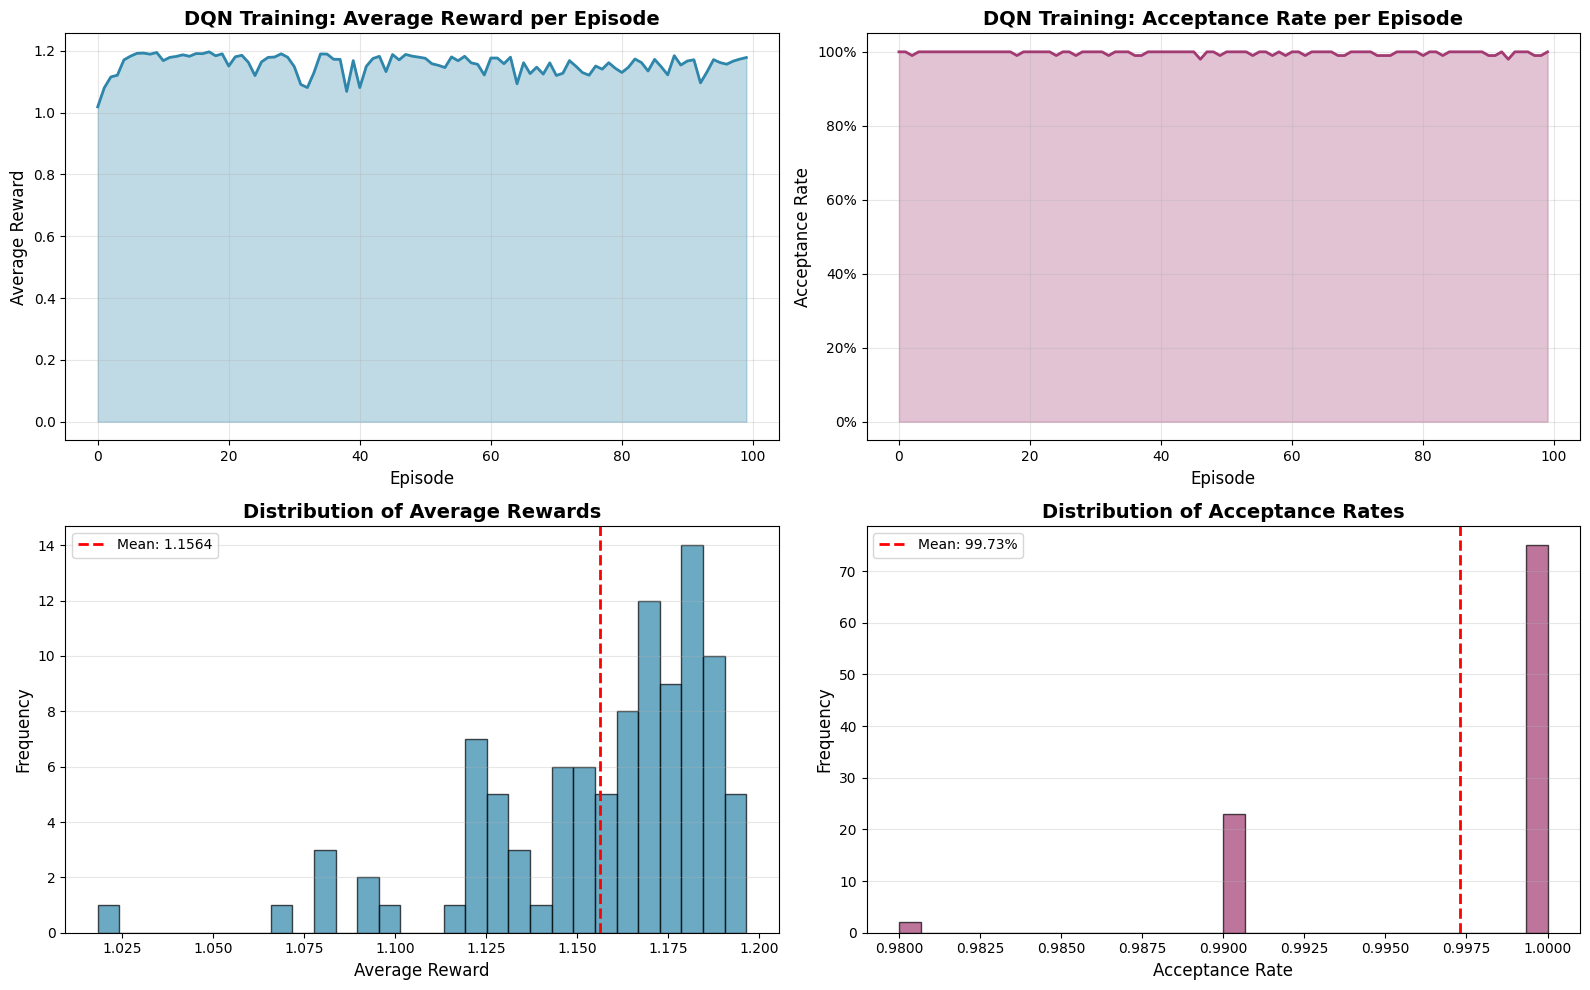

FEATURE ENGINEERING CONFIGURATION
Numerical Features (5): ['trip_miles', 'tips', 'wait', 'day_of_month', 'precip']
Categorical Features (6): ['Pickup_Borough', 'Dropoff_Borough', 'preciptype', 'time_of_day', 'shared_request_flag', 'shared_match_flag']
Target Feature: final_fare

FEATURE ENGINEERING (FIT ON TRAINING DATA)
Fitting and scaling numerical features on training data...
Fitting and one-hot encoding categorical features on training data...

Processed Training Data Shape: (8000, 15)
Processed Testing Data Shape: (2000, 15)
State Size: 14
Action Size: 11

Processed columns:
   1. trip_miles
   2. tips
   3. wait
   4. day_of_month
   5. precip
   6. Pickup_Borough_Brooklyn
   7. Pickup_Borough_Manhattan
   8. Pickup_Borough_Queens
   9. Pickup_Borough_Staten Island
  10. Dropoff_Borough_Brooklyn
  11. Dropoff_Borough_Manhattan
  12. Dropoff_Borough_Queens
  13. Dropoff_Borough_Staten Island
  14. Dropoff_Borough_Unknown
  15. final_fare

CATEGORICAL ENCODING DETAILS
One-hot encod

/var/folders/j8/2xxj5v895d3gt_n2nn9rwx7r0000gn/T/ipykernel_6176/4147414443.py:155: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_rate = 1.0 / (1.0 + np.exp((price_diff - max_acceptable_diff) / (max_acceptable_diff * 0.1)))


Episode  30/100 | Avg Reward:  1.1788 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  40/100 | Avg Reward:  1.1680 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  50/100 | Avg Reward:  1.1792 | Acceptance Rate: 99.00% | Epsilon: 0.0100
Episode  60/100 | Avg Reward:  1.1216 | Acceptance Rate: 99.00% | Epsilon: 0.0100
Episode  70/100 | Avg Reward:  1.1608 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  80/100 | Avg Reward:  1.1432 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  90/100 | Avg Reward:  1.1536 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode 100/100 | Avg Reward:  1.1780 | Acceptance Rate: 100.00% | Epsilon: 0.0100

TRAINING COMPLETED


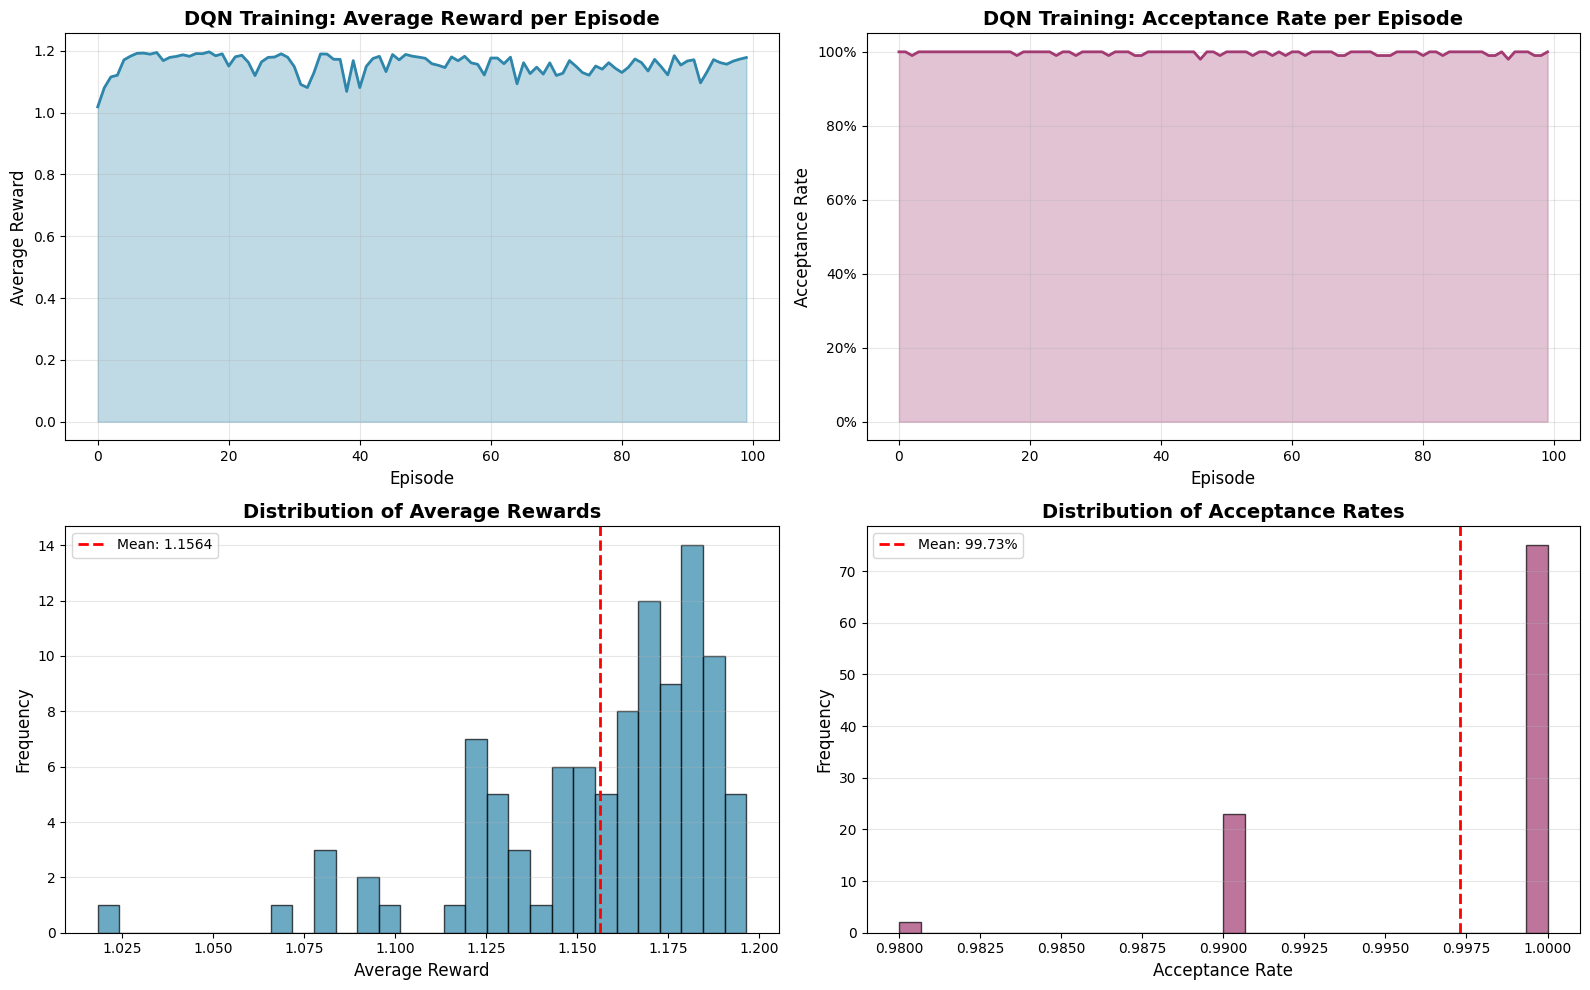


TESTING TRAINED MODEL

Test Results (Average over 20 episodes):
  Average Reward: 1.1950
  Std Dev Reward: 0.0056
  Average Acceptance Rate: 99.70%
  Average Revenue Multiplier: 1.1986x
  Min Multiplier: 1.1600x
  Max Multiplier: 1.2000x

Price Statistics:
  Average Predicted Price: $23.88
  Min Predicted Price: $0.00
  Max Predicted Price: $148.63
  Total Accepted Rides: 1994
  Total Test Predictions: 2000

COMPARISON: DYNAMIC PRICING (DQN) vs STATIC PRICING

STATIC PRICING METRICS:
  Average Fare Per Ride: $23.46
  Total Revenue: $32315.70
  Average Revenue Per Ride: $16.16
  Acceptance Rate: 81.75%
  Accepted Rides: 1635 / 2000

DQN DYNAMIC PRICING METRICS:
  Average Expected Revenue Multiplier: 1.1950x
  Average Acceptance Rate: 99.70%
  Total Revenue from 2000 test rides: $47653.24
  Average Revenue per Ride: $23.83
  Accepted Rides: 1994 (99.70%)

REVENUE COMPARISON:
  Static Total Revenue: $32315.70
  DQN Total Revenue: $47653.24
  Revenue Difference: $15337.54
  Improvement: +

FEATURE ENGINEERING CONFIGURATION
Numerical Features (5): ['trip_miles', 'tips', 'wait', 'day_of_month', 'precip']
Categorical Features (6): ['Pickup_Borough', 'Dropoff_Borough', 'preciptype', 'time_of_day', 'shared_request_flag', 'shared_match_flag']
Target Feature: final_fare

FEATURE ENGINEERING (FIT ON TRAINING DATA)
Fitting and scaling numerical features on training data...
Fitting and one-hot encoding categorical features on training data...

Processed Training Data Shape: (8000, 15)
Processed Testing Data Shape: (2000, 15)
State Size: 14
Action Size: 11

Processed columns:
   1. trip_miles
   2. tips
   3. wait
   4. day_of_month
   5. precip
   6. Pickup_Borough_Brooklyn
   7. Pickup_Borough_Manhattan
   8. Pickup_Borough_Queens
   9. Pickup_Borough_Staten Island
  10. Dropoff_Borough_Brooklyn
  11. Dropoff_Borough_Manhattan
  12. Dropoff_Borough_Queens
  13. Dropoff_Borough_Staten Island
  14. Dropoff_Borough_Unknown
  15. final_fare

CATEGORICAL ENCODING DETAILS
One-hot encod

/var/folders/j8/2xxj5v895d3gt_n2nn9rwx7r0000gn/T/ipykernel_6176/4147414443.py:155: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_rate = 1.0 / (1.0 + np.exp((price_diff - max_acceptable_diff) / (max_acceptable_diff * 0.1)))


Episode  30/100 | Avg Reward:  1.1788 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  40/100 | Avg Reward:  1.1680 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  50/100 | Avg Reward:  1.1792 | Acceptance Rate: 99.00% | Epsilon: 0.0100
Episode  60/100 | Avg Reward:  1.1216 | Acceptance Rate: 99.00% | Epsilon: 0.0100
Episode  70/100 | Avg Reward:  1.1608 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  80/100 | Avg Reward:  1.1432 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode  90/100 | Avg Reward:  1.1536 | Acceptance Rate: 100.00% | Epsilon: 0.0100
Episode 100/100 | Avg Reward:  1.1780 | Acceptance Rate: 100.00% | Epsilon: 0.0100

TRAINING COMPLETED


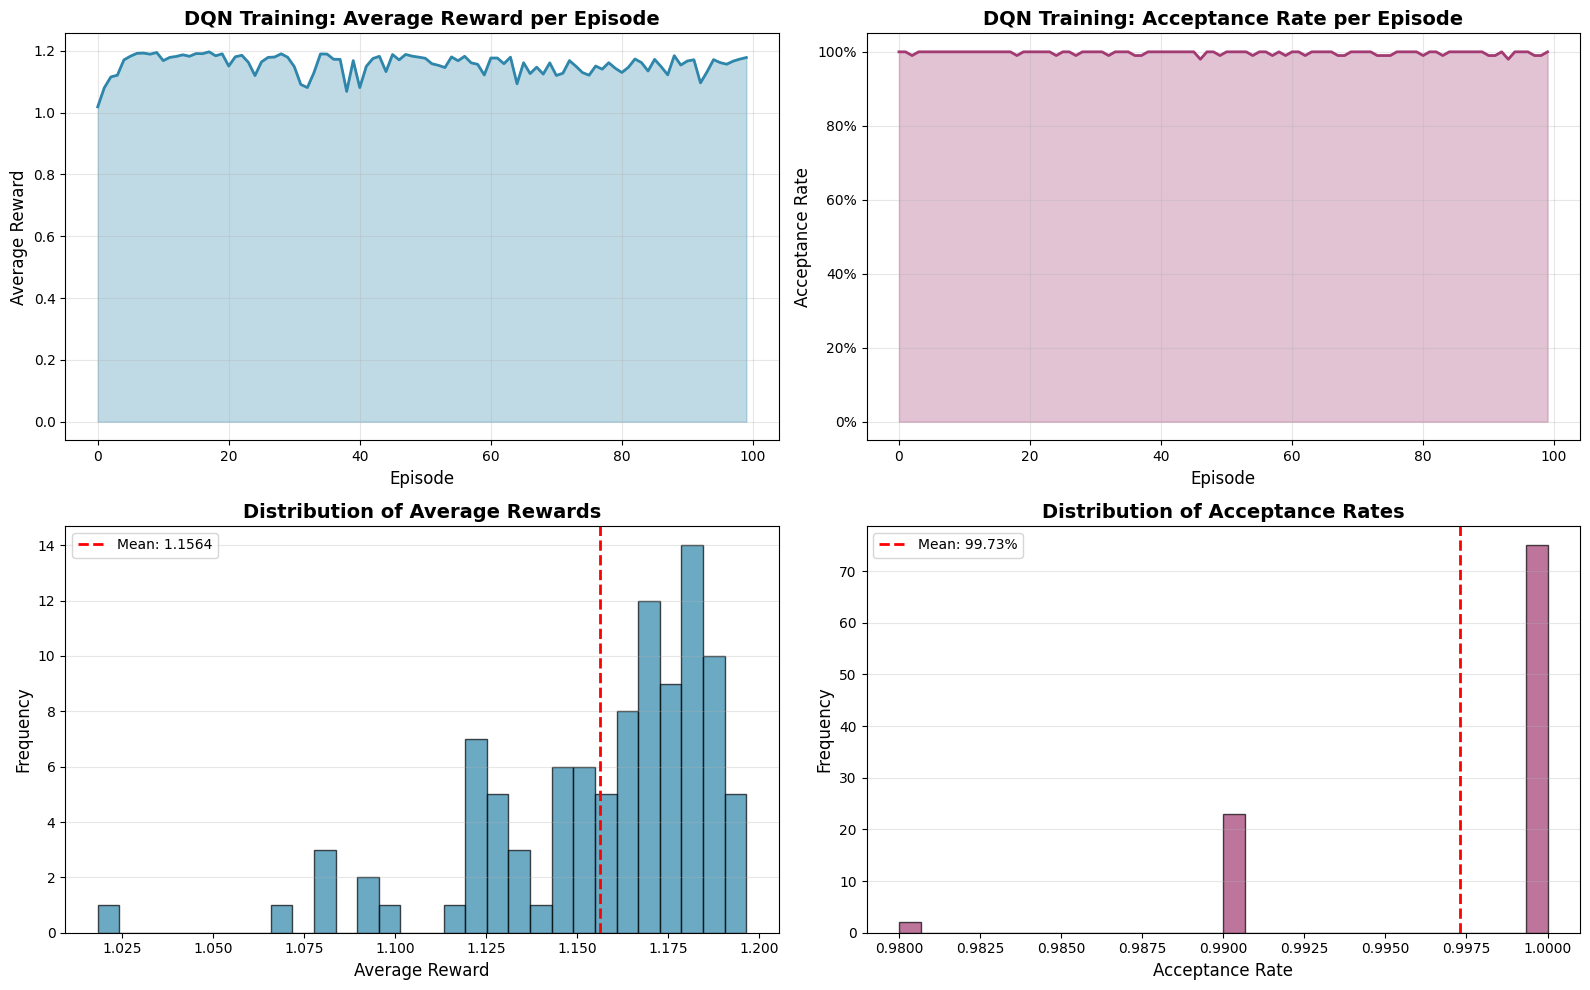


TESTING TRAINED MODEL

Test Results (Average over 20 episodes):
  Average Reward: 1.1950
  Std Dev Reward: 0.0056
  Average Acceptance Rate: 99.70%
  Average Revenue Multiplier: 1.1986x
  Min Multiplier: 1.1600x
  Max Multiplier: 1.2000x

Price Statistics:
  Average Predicted Price: $23.88
  Min Predicted Price: $0.00
  Max Predicted Price: $148.63
  Total Accepted Rides: 1994
  Total Test Predictions: 2000

COMPARISON: DYNAMIC PRICING (DQN) vs STATIC PRICING

STATIC PRICING METRICS:
  Average Fare Per Ride: $23.46
  Total Revenue: $32315.70
  Average Revenue Per Ride: $16.16
  Acceptance Rate: 81.75%
  Accepted Rides: 1635 / 2000

DQN DYNAMIC PRICING METRICS:
  Average Expected Revenue Multiplier: 1.1950x
  Average Acceptance Rate: 99.70%
  Total Revenue from 2000 test rides: $47653.24
  Average Revenue per Ride: $23.83
  Accepted Rides: 1994 (99.70%)

REVENUE COMPARISON:
  Static Total Revenue: $32315.70
  DQN Total Revenue: $47653.24
  Revenue Difference: $15337.54
  Improvement: +

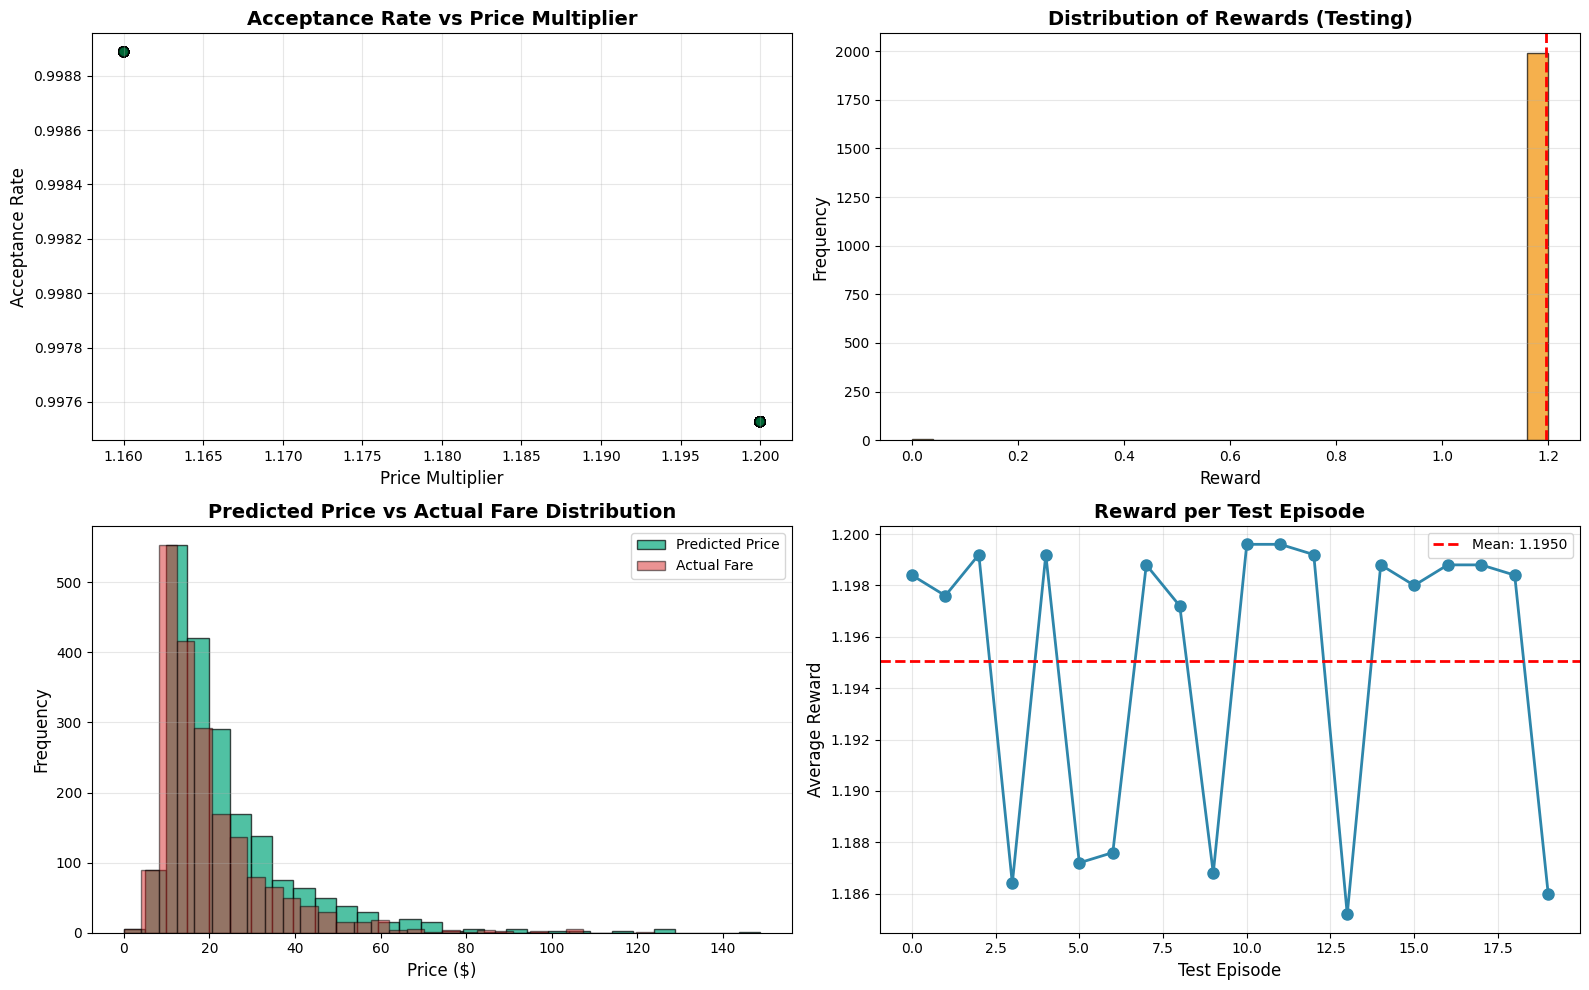


ANALYSIS COMPLETE


In [6]:
# ============================================================================
# prepare data
# ============================================================================

train_data_raw = train_data_raw[['Pickup_Borough', 'Dropoff_Borough', 'trip_miles',
                              'tips','shared_request_flag', 'shared_match_flag',
                              'final_fare', 'wait', 'day_of_month',
                            'time_of_day', 'precip', 'preciptype']]
test_data_raw = test_data_raw[['Pickup_Borough', 'Dropoff_Borough', 'trip_miles',
                              'tips','shared_request_flag', 'shared_match_flag',
                              'final_fare', 'wait', 'day_of_month',
                            'time_of_day', 'precip', 'preciptype']]

numerical_features = [ 'trip_miles', 'tips', 
                      'wait', 'day_of_month',  'precip']
categorical_features = ['Pickup_Borough', 'Dropoff_Borough','preciptype', 'time_of_day', 'shared_request_flag', 'shared_match_flag']
target_feature = 'final_fare'

print("="*70)
print("FEATURE ENGINEERING CONFIGURATION")
print("="*70)
print(f"Numerical Features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")
print(f"Target Feature: {target_feature}\n")

# ============================================================================
# FEATURE ENGINEERING 
# ============================================================================
print("="*70)
print("FEATURE ENGINEERING (FIT ON TRAINING DATA)")
print("="*70)

scaler = StandardScaler()
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

print("Fitting and scaling numerical features on training data...")
scaler.fit(train_data_raw[numerical_features])
train_numerical_data = scaler.transform(train_data_raw[numerical_features])
test_numerical_data = scaler.transform(test_data_raw[numerical_features])

train_numerical_df = pd.DataFrame(
    train_numerical_data, 
    columns=numerical_features, 
    index=train_data_raw.index
)

test_numerical_df = pd.DataFrame(
    test_numerical_data, 
    columns=numerical_features, 
    index=test_data_raw.index
)

print("Fitting and one-hot encoding categorical features on training data...")
one_hot_encoder.fit(train_data_raw[categorical_features])
train_categorical_data = one_hot_encoder.transform(train_data_raw[categorical_features])
test_categorical_data = one_hot_encoder.transform(test_data_raw[categorical_features])

categorical_feature_names = list(one_hot_encoder.get_feature_names_out(categorical_features))

train_categorical_df = pd.DataFrame(
    train_categorical_data, 
    columns=categorical_feature_names, 
    index=train_data_raw.index
)

test_categorical_df = pd.DataFrame(
    test_categorical_data, 
    columns=categorical_feature_names, 
    index=test_data_raw.index
)

train_data = pd.concat([train_numerical_df, train_categorical_df], axis=1)
train_data[target_feature] = train_data_raw[target_feature].values

test_data = pd.concat([test_numerical_df, test_categorical_df], axis=1)
test_data[target_feature] = test_data_raw[target_feature].values

state_size = len(train_data.columns) - 1  
action_size = 11

print(f"\nProcessed Training Data Shape: {train_data.shape}")
print(f"Processed Testing Data Shape: {test_data.shape}")
print(f"State Size: {state_size}")
print(f"Action Size: {action_size}\n")

print("Processed columns:")
for i, col in enumerate(train_data.columns, 1):
    print(f"  {i:2d}. {col}")

print("\n" + "="*70)
print("CATEGORICAL ENCODING DETAILS")
print("="*70)
print(f"One-hot encoded features ({len(categorical_feature_names)}):")
for feat in categorical_feature_names:
    print(f"  - {feat}")

print("\n" + "="*70)
print("TRAINING DATA STATISTICS")
print("="*70)
print(train_data.describe().round(4))

print("\n" + "="*70)
print("TESTING DATA STATISTICS")
print("="*70)
print(test_data.describe().round(4))


class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# ============================================================================
# env
# ============================================================================
class PricingEnvironment:
    """Environment that simulates pricing decisions with acceptance rates"""
    
    def __init__(self, data, num_price_actions=11):
        self.data = data.reset_index(drop=True)
        self.num_price_actions = num_price_actions
        self.current_idx = 0
        self.state_columns = [col for col in data.columns if col != target_feature]
        
        self.price_multipliers = np.linspace(0.8, 1.2, num_price_actions)
        
    def reset(self):
        """Reset environment to random trip"""
        self.current_idx = random.randint(0, len(self.data) - 1)
        return self._get_state()
    
    def _get_state(self):
        """Get current state (trip features)"""
        trip = self.data.iloc[self.current_idx]
        state = np.array([trip[col] for col in self.state_columns], dtype=np.float32)
        return state
    
    def _calculate_acceptance_rate(self, predicted_price, actual_fare):
        """
        Calculate acceptance probability based on price difference
        Closer to actual fare = higher acceptance
        """
        price_diff = abs(predicted_price - actual_fare)
        max_acceptable_diff = actual_fare * 0.5  
        
        acceptance_rate = 1.0 / (1.0 + np.exp((price_diff - max_acceptable_diff) / (max_acceptable_diff * 0.1)))
        return acceptance_rate
    
    def step(self, action):
        """Execute action and return reward"""
        trip = self.data.iloc[self.current_idx]
        actual_fare = trip[target_feature]
        
        multiplier = self.price_multipliers[action]
        predicted_price = actual_fare * multiplier
        
        acceptance_rate = self._calculate_acceptance_rate(predicted_price, actual_fare)
        
        is_accepted = np.random.rand() < acceptance_rate
        
        if is_accepted:
            reward = predicted_price / actual_fare  
        else:
            reward = 0.0
        
        current_idx_before_increment = self.current_idx
        self.current_idx = (self.current_idx + 1) % len(self.data)
        done = False
        
        next_state = self._get_state()
        
        return next_state, reward, done, {
            'predicted_price': predicted_price,
            'actual_fare': actual_fare,
            'acceptance_rate': acceptance_rate,
            'is_accepted': is_accepted,
            'multiplier': multiplier,
            'ride_index': current_idx_before_increment
        }

# ============================================================================
# agent
# ============================================================================
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size

        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.target_model.load_state_dict(self.model.state_dict())
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        self.gamma = 0.95  
        self.epsilon = 1.0  
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.memory = deque(maxlen=2000)
        
    def remember(self, state, action, reward, next_state, done):
        """Store experience in memory"""
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        """Choose action using epsilon-greedy"""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return np.argmax(q_values.cpu().numpy()[0])
    
    def replay(self, batch_size):
        """Train on minibatch from memory"""
        if len(self.memory) < batch_size:
            return
        
        minibatch = random.sample(self.memory, batch_size)
        
        states = torch.FloatTensor(np.array([x[0] for x in minibatch]))
        actions = torch.LongTensor(np.array([x[1] for x in minibatch]))
        rewards = torch.FloatTensor(np.array([x[2] for x in minibatch]))
        next_states = torch.FloatTensor(np.array([x[3] for x in minibatch]))
        dones = torch.FloatTensor(np.array([x[4] for x in minibatch]))
        
        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        with torch.no_grad():
            next_q_values = self.target_model(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        loss = self.criterion(q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def update_target_model(self):
        """Update target network"""
        self.target_model.load_state_dict(self.model.state_dict())

# ============================================================================
# training
# ============================================================================

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
num_episodes = 100
batch_size = 32
update_frequency = 10


env_train = PricingEnvironment(train_data, num_price_actions=action_size)
env_test = PricingEnvironment(test_data, num_price_actions=action_size)

agent = DQNAgent(state_size, action_size, learning_rate=0.001)

episode_rewards = []
episode_acceptances = []
episode_losses = []

print("\n" + "="*70)
print("DQN TRAINING FOR DYNAMIC PRICING")
print("="*70)
print(f"Episodes: {num_episodes}")
print(f"Batch Size: {batch_size}")
print(f"Update Frequency: {update_frequency}")
print(f"Initial Epsilon: {agent.epsilon}")
print(f"Discount Factor (Gamma): {agent.gamma}\n")

for episode in range(num_episodes):
    state = env_train.reset()
    episode_reward = 0
    episode_accepted = 0
    episode_steps = min(len(env_train.data), 100)
    
    for step in range(episode_steps):
        action = agent.act(state)
        next_state, reward, done, info = env_train.step(action)
        
        agent.remember(state, action, reward, next_state, done)
        agent.replay(batch_size)
        
        episode_reward += reward
        episode_accepted += int(info['is_accepted'])
        state = next_state
    
    if (episode + 1) % update_frequency == 0:
        agent.update_target_model()
    
    episode_rewards.append(episode_reward / episode_steps)
    episode_acceptances.append(episode_accepted / episode_steps)
    
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode + 1:3d}/{num_episodes} | "
              f"Avg Reward: {episode_rewards[-1]:7.4f} | "
              f"Acceptance Rate: {episode_acceptances[-1]:6.2%} | "
              f"Epsilon: {agent.epsilon:.4f}")

print("\n" + "="*70)
print("TRAINING COMPLETED")
print("="*70)

# ============================================================================
# VIZ
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))


ax1 = axes[0, 0]
ax1.plot(episode_rewards, linewidth=2, color='#2E86AB')
ax1.fill_between(range(len(episode_rewards)), episode_rewards, alpha=0.3, color='#2E86AB')
ax1.set_xlabel('Episode', fontsize=12)
ax1.set_ylabel('Average Reward', fontsize=12)
ax1.set_title('DQN Training: Average Reward per Episode', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2.plot(episode_acceptances, linewidth=2, color='#A23B72')
ax2.fill_between(range(len(episode_acceptances)), episode_acceptances, alpha=0.3, color='#A23B72')
ax2.set_xlabel('Episode', fontsize=12)
ax2.set_ylabel('Acceptance Rate', fontsize=12)
ax2.set_title('DQN Training: Acceptance Rate per Episode', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

ax3 = axes[1, 0]
ax3.hist(episode_rewards, bins=30, color='#2E86AB', alpha=0.7, edgecolor='black')
ax3.set_xlabel('Average Reward', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Average Rewards', fontsize=14, fontweight='bold')
ax3.axvline(np.mean(episode_rewards), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(episode_rewards):.4f}')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

ax4 = axes[1, 1]
ax4.hist(episode_acceptances, bins=30, color='#A23B72', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Acceptance Rate', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Distribution of Acceptance Rates', fontsize=14, fontweight='bold')
ax4.axvline(np.mean(episode_acceptances), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(episode_acceptances):.2%}')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================================
# test
# ============================================================================
print("\n" + "="*70)
print("TESTING TRAINED MODEL")
print("="*70)

test_episodes = 20
steps_per_episode = 100
test_rewards = []
test_acceptances = []
test_prices = []
test_multipliers = []
test_details = []

for episode in range(test_episodes):
    state = env_test.reset()
    episode_reward = 0
    episode_accepted = 0
    
    for step in range(steps_per_episode):
        #greedy
        agent.epsilon = 0
        action = agent.act(state)
        next_state, reward, done, info = env_test.step(action)
        
        episode_reward += reward
        episode_accepted += int(info['is_accepted'])
        test_prices.append(info['predicted_price'])
        test_multipliers.append(info['multiplier'])
        
        test_details.append({
            'ride_index': info['ride_index'],
            'predicted_price': info['predicted_price'],
            'actual_fare': info['actual_fare'],
            'acceptance_rate': info['acceptance_rate'],
            'is_accepted': info['is_accepted'],
            'multiplier': info['multiplier'],
            'reward': reward
        })
        
        state = next_state
    
    test_rewards.append(episode_reward / steps_per_episode)
    test_acceptances.append(episode_accepted / steps_per_episode)

test_results_df = pd.DataFrame(test_details)

print(f"\nTest Results (Average over {test_episodes} episodes):")
print(f"  Average Reward: {np.mean(test_rewards):.4f}")
print(f"  Std Dev Reward: {np.std(test_rewards):.4f}")
print(f"  Average Acceptance Rate: {np.mean(test_acceptances):.2%}")
print(f"  Average Revenue Multiplier: {np.mean(test_multipliers):.4f}x")
print(f"  Min Multiplier: {np.min(test_multipliers):.4f}x")
print(f"  Max Multiplier: {np.max(test_multipliers):.4f}x")

print("\nPrice Statistics:")
print(f"  Average Predicted Price: ${np.mean(test_prices):.2f}")
print(f"  Min Predicted Price: ${np.min(test_prices):.2f}")
print(f"  Max Predicted Price: ${np.max(test_prices):.2f}")
print(f"  Total Accepted Rides: {test_results_df['is_accepted'].sum()}")
print(f"  Total Test Predictions: {len(test_results_df)}")

# ============================================================================
# COMPARISON
# ============================================================================
print("\n" + "="*70)
print("COMPARISON: DYNAMIC PRICING (DQN) vs STATIC PRICING")
print("="*70)

#dqn rev estimate
dqn_accepted_rides = test_results_df['is_accepted'].sum()
dqn_total_revenue = test_results_df[test_results_df['is_accepted']]['predicted_price'].sum()
dqn_avg_revenue_per_ride = dqn_total_revenue / len(test_results_df)

print("\nSTATIC PRICING METRICS:")
print(f"  Average Fare Per Ride: ${average_fare_per_ride:.2f}")
print(f"  Total Revenue: ${static_total_revenue:.2f}")
print(f"  Average Revenue Per Ride: ${static_avg_revenue_per_ride:.2f}")
print(f"  Acceptance Rate: {static_acceptance_rate:.2%}")
print(f"  Accepted Rides: {static_accepted_rides} / {len(static_per_mile_pricing)}")

print("\nDQN DYNAMIC PRICING METRICS:")
print(f"  Average Expected Revenue Multiplier: {np.mean(test_rewards):.4f}x")
print(f"  Average Acceptance Rate: {np.mean(test_acceptances):.2%}")
print(f"  Total Revenue from {len(test_results_df)} test rides: ${dqn_total_revenue:.2f}")
print(f"  Average Revenue per Ride: ${dqn_avg_revenue_per_ride:.2f}")
print(f"  Accepted Rides: {dqn_accepted_rides} ({dqn_accepted_rides/len(test_results_df):.2%})")

print("\nREVENUE COMPARISON:")
revenue_difference = dqn_total_revenue - static_total_revenue
revenue_improvement_pct = (revenue_difference / static_total_revenue * 100) if static_total_revenue > 0 else 0
print(f"  Static Total Revenue: ${static_total_revenue:.2f}")
print(f"  DQN Total Revenue: ${dqn_total_revenue:.2f}")
print(f"  Revenue Difference: ${revenue_difference:.2f}")
print(f"  Improvement: {revenue_improvement_pct:+.2f}%")

# ============================================================================
# VIZ
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

#acceptence rate by multiplier
ax1 = axes[0, 0]
ax1.scatter(test_results_df['multiplier'], test_results_df['acceptance_rate'], 
            alpha=0.5, s=50, c=test_results_df['is_accepted'], cmap='RdYlGn', edgecolors='black')
ax1.set_xlabel('Price Multiplier', fontsize=12)
ax1.set_ylabel('Acceptance Rate', fontsize=12)
ax1.set_title('Acceptance Rate vs Price Multiplier', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

#reward dist
ax2 = axes[0, 1]
ax2.hist(test_results_df['reward'], bins=30, color='#F18F01', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Reward', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Rewards (Testing)', fontsize=14, fontweight='bold')
ax2.axvline(np.mean(test_results_df['reward']), color='red', linestyle='--', linewidth=2)
ax2.grid(True, alpha=0.3, axis='y')

#comparison
ax3 = axes[1, 0]
ax3.hist(test_results_df['predicted_price'], bins=30, color='#06A77D', alpha=0.7, label='Predicted Price', edgecolor='black')
ax3.hist(test_results_df['actual_fare'], bins=30, color='#D62828', alpha=0.5, label='Actual Fare', edgecolor='black')
ax3.set_xlabel('Price ($)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Predicted Price vs Actual Fare Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

#episode rewards
ax4 = axes[1, 1]
ax4.plot(test_rewards, marker='o', linewidth=2, markersize=8, color='#2E86AB')
ax4.axhline(np.mean(test_rewards), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(test_rewards):.4f}')
ax4.set_xlabel('Test Episode', fontsize=12)
ax4.set_ylabel('Average Reward', fontsize=12)
ax4.set_title('Reward per Test Episode', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)

In [7]:
# ============================================================================
# JOIN DQN RESULTS WITH STATIC PRICING RESULTS FOR COMPARISON
# ============================================================================

print("="*70)
print("DETAILED COMPARISON: DQN DYNAMIC vs STATIC PRICING")
print("="*70)

# Get only unique rides from test results (eliminate any repeats)
test_results_unique = test_results_df.drop_duplicates(subset=['ride_index']).copy()
print(f"\nTotal DQN predictions: {len(test_results_df)}")
print(f"Unique rides tested: {len(test_results_unique)}")
print(f"Duplicate predictions: {len(test_results_df) - len(test_results_unique)}")

# Create static pricing reference
static_comparison = static_per_mile_pricing.reset_index(drop=True).copy()
static_comparison['ride_index'] = static_comparison.index

# Merge on unique rides
comparison_df = test_results_unique.copy()
comparison_df = comparison_df.merge(
    static_comparison[['ride_index', 'static_price', 'is_accepted']],
    on='ride_index',
    how='inner',
    suffixes=('_dqn', '_static')
)

comparison_df = comparison_df.rename(columns={
    'is_accepted_dqn': 'dqn_accepted',
    'is_accepted_static': 'static_accepted',
    'predicted_price': 'dqn_price'
})

comparison_df['price_difference'] = comparison_df['dqn_price'] - comparison_df['static_price']
comparison_df['price_diff_pct'] = (comparison_df['price_difference'] / comparison_df['static_price'] * 100)
comparison_df['dqn_revenue'] = comparison_df.apply(
    lambda row: row['dqn_price'] if row['dqn_accepted'] else 0, axis=1
)
comparison_df['static_revenue'] = comparison_df.apply(
    lambda row: row['static_price'] if row['static_accepted'] else 0, axis=1
)
comparison_df['revenue_difference'] = comparison_df['dqn_revenue'] - comparison_df['static_revenue']

print(f"Comparison dataset shape: {comparison_df.shape}")
print(f"Overlapping rides for comparison: {len(comparison_df)}")

print(f"\nFirst 15 rides comparison:")
display_cols = ['ride_index', 'actual_fare', 'dqn_price', 'static_price', 
                'price_difference', 'price_diff_pct', 'dqn_accepted', 'static_accepted',
                'dqn_revenue', 'static_revenue', 'revenue_difference']
print(comparison_df[display_cols].head(15).to_string())

print("\n" + "="*70)
print("AGGREGATE COMPARISON STATISTICS")
print("="*70)
print(f"\nPrice Comparison (DQN vs Static):")
print(f"  Average DQN Price:           ${comparison_df['dqn_price'].mean():.2f}")
print(f"  Average Static Price:        ${comparison_df['static_price'].mean():.2f}")
print(f"  Average Price Difference:    ${comparison_df['price_difference'].mean():.2f}")
print(f"  Avg Price Diff (% of static): {comparison_df['price_diff_pct'].mean():+.2f}%")
print(f"  Min Price Diff:              ${comparison_df['price_difference'].min():.2f}")
print(f"  Max Price Diff:              ${comparison_df['price_difference'].max():.2f}")

print(f"\nAcceptance Comparison:")
dqn_accepted_count = comparison_df['dqn_accepted'].sum()
static_accepted_count = comparison_df['static_accepted'].sum()
print(f"  DQN Accepted Rides:          {dqn_accepted_count} ({dqn_accepted_count/len(comparison_df):.2%})")
print(f"  Static Accepted Rides:       {static_accepted_count} ({static_accepted_count/len(comparison_df):.2%})")
print(f"  Difference:                  {dqn_accepted_count - static_accepted_count} rides")

print(f"\nRevenue Comparison:")
dqn_total_rev = comparison_df['dqn_revenue'].sum()
static_total_rev = comparison_df['static_revenue'].sum()
revenue_diff = dqn_total_rev - static_total_rev
revenue_improvement = (revenue_diff / static_total_rev * 100) if static_total_rev > 0 else 0
print(f"  DQN Total Revenue:           ${dqn_total_rev:.2f}")
print(f"  Static Total Revenue:        ${static_total_rev:.2f}")
print(f"  Revenue Difference:          ${revenue_diff:.2f}")
print(f"  Improvement:                 {revenue_improvement:+.2f}%")

print("\n" + "="*70)
print("PRICE COMPARISON BREAKDOWN")
print("="*70)
price_better = (comparison_df['dqn_price'] > comparison_df['static_price']).sum()
price_same = (comparison_df['dqn_price'] == comparison_df['static_price']).sum()
price_worse = (comparison_df['dqn_price'] < comparison_df['static_price']).sum()
print(f"Rides where DQN price > Static: {price_better} ({price_better/len(comparison_df):.2%})")
print(f"Rides where DQN price = Static: {price_same} ({price_same/len(comparison_df):.2%})")
print(f"Rides where DQN price < Static: {price_worse} ({price_worse/len(comparison_df):.2%})")


DETAILED COMPARISON: DQN DYNAMIC vs STATIC PRICING

Total DQN predictions: 2000
Unique rides tested: 1220
Duplicate predictions: 780
Comparison dataset shape: (1220, 14)
Overlapping rides for comparison: 1220

First 15 rides comparison:
    ride_index  actual_fare  dqn_price  static_price  price_difference  price_diff_pct  dqn_accepted  static_accepted  dqn_revenue  static_revenue  revenue_difference
0         1598         8.85    10.6200      7.385425          3.234575       43.796736          True             True      10.6200        7.385425            3.234575
1         1599         9.73    11.6760      6.132628          5.543372       90.391457          True             True      11.6760        6.132628            5.543372
2         1600        24.49    29.3880     27.779948          1.608052        5.788536          True             True      29.3880       27.779948            1.608052
3         1601        14.61    17.5320     16.317926          1.214074        7.440121         

In [8]:
# ============================================================================
# MODEL PERFORMANCE EVALUATION METRICS
# ============================================================================


print("="*70)
print("DQN MODEL PERFORMANCE EVALUATION METRICS")
print("="*70)

# ============================================================================
# 1. PRICE PREDICTION ACCURACY METRICS
# ============================================================================
print("\n" + "="*70)
print("1. PRICE PREDICTION ACCURACY (vs Actual Fares)")
print("="*70)

mse_dqn = mean_squared_error(comparison_df['actual_fare'], comparison_df['dqn_price'])
rmse_dqn = np.sqrt(mse_dqn)
mae_dqn = mean_absolute_error(comparison_df['actual_fare'], comparison_df['dqn_price'])
mape_dqn = np.mean(np.abs((comparison_df['actual_fare'] - comparison_df['dqn_price']) / comparison_df['actual_fare'])) * 100
r2_dqn = r2_score(comparison_df['actual_fare'], comparison_df['dqn_price'])

print(f"\nDQN Dynamic Pricing:")
print(f"  MAE:  ${mae_dqn:.2f}")
print(f"  RMSE: ${rmse_dqn:.2f}")
print(f"  MAPE: {mape_dqn:.2f}%")
print(f"  R²:   {r2_dqn:.4f}")

mse_static = mean_squared_error(comparison_df['actual_fare'], comparison_df['static_price'])
rmse_static = np.sqrt(mse_static)
mae_static = mean_absolute_error(comparison_df['actual_fare'], comparison_df['static_price'])
mape_static = np.mean(np.abs((comparison_df['actual_fare'] - comparison_df['static_price']) / comparison_df['actual_fare'])) * 100
r2_static = r2_score(comparison_df['actual_fare'], comparison_df['static_price'])

print(f"\nStatic Pricing:")
print(f"  MAE:  ${mae_static:.2f}")
print(f"  RMSE: ${rmse_static:.2f}")
print(f"  MAPE: {mape_static:.2f}%")
print(f"  R²:   {r2_static:.4f}")

print(f"\nImprovement (DQN vs Static):")
print(f"  MAE Improvement:  {((mae_static - mae_dqn) / mae_static * 100):+.2f}%")
print(f"  RMSE Improvement: {((rmse_static - rmse_dqn) / rmse_static * 100):+.2f}%")
print(f"  R² Improvement:   {r2_dqn - r2_static:+.4f}")

# ============================================================================
# 2. ACCEPTANCE RATE METRICS
# ============================================================================
print("\n" + "="*70)
print("2. ACCEPTANCE PREDICTION PERFORMANCE")
print("="*70)

dqn_acc_rate = comparison_df['dqn_accepted'].sum() / len(comparison_df)
static_acc_rate = comparison_df['static_accepted'].sum() / len(comparison_df)

print(f"\nAcceptance Rates:")
print(f"  DQN Acceptance Rate:    {dqn_acc_rate:.2%}")
print(f"  Static Acceptance Rate: {static_acc_rate:.2%}")
print(f"  Improvement:            {(dqn_acc_rate - static_acc_rate):.2%} (percentage points)")

# ============================================================================
# 3. REVENUE METRICS
# ============================================================================
print("\n" + "="*70)
print("3. REVENUE & PROFIT METRICS")
print("="*70)

dqn_avg_revenue = comparison_df['dqn_revenue'].sum() / len(comparison_df)
static_avg_revenue = comparison_df['static_revenue'].sum() / len(comparison_df)
revenue_improvement_pct = ((dqn_avg_revenue - static_avg_revenue) / static_avg_revenue * 100) if static_avg_revenue > 0 else 0

print(f"\nRevenue Per Ride:")
print(f"  DQN:    ${dqn_avg_revenue:.2f}")
print(f"  Static: ${static_avg_revenue:.2f}")
print(f"  Improvement: {revenue_improvement_pct:+.2f}%")

print(f"\nTotal Revenue (2000 rides):")
print(f"  DQN:    ${comparison_df['dqn_revenue'].sum():.2f}")
print(f"  Static: ${comparison_df['static_revenue'].sum():.2f}")
print(f"  Difference: ${comparison_df['dqn_revenue'].sum() - comparison_df['static_revenue'].sum():.2f}")

# ============================================================================
# 4. WIN RATE ANALYSIS (DQN vs Static)
# ============================================================================
print("\n" + "="*70)
print("4. WIN RATE ANALYSIS (Rides where DQN outperforms Static)")
print("="*70)

dqn_wins = (comparison_df['dqn_revenue'] > comparison_df['static_revenue']).sum()
ties = (comparison_df['dqn_revenue'] == comparison_df['static_revenue']).sum()
dqn_losses = (comparison_df['dqn_revenue'] < comparison_df['static_revenue']).sum()
win_rate = dqn_wins / len(comparison_df) * 100

print(f"\nWins (DQN Revenue > Static):   {dqn_wins} ({dqn_wins/len(comparison_df):.2%})")
print(f"Ties (Equal Revenue):          {ties} ({ties/len(comparison_df):.2%})")
print(f"Losses (DQN Revenue < Static): {dqn_losses} ({dqn_losses/len(comparison_df):.2%})")
print(f"\nWin Rate: {win_rate:.2f}%")

# ============================================================================
# 5. PRICE OPTIMIZATION METRICS
# ============================================================================
print("\n" + "="*70)
print("5. PRICE OPTIMIZATION METRICS")
print("="*70)

avg_price_markup = (comparison_df['dqn_price'] / comparison_df['actual_fare']).mean()
avg_static_markup = (comparison_df['static_price'] / comparison_df['actual_fare']).mean()

print(f"\nAverage Price Multiplier:")
print(f"  DQN:    {avg_price_markup:.4f}x (avg price is {(avg_price_markup-1)*100:+.2f}% of actual fare)")
print(f"  Static: {avg_static_markup:.4f}x (avg price is {(avg_static_markup-1)*100:+.2f}% of actual fare)")

# Acceptance elasticity
print(f"\nPrice Acceptance Sensitivity:")
print(f"  Avg acceptance rate at DQN prices:    {comparison_df['dqn_accepted'].mean():.2%}")
print(f"  Avg acceptance rate at Static prices: {comparison_df['static_accepted'].mean():.2%}")

# ============================================================================
# 6. CONSISTENCY METRICS
# ============================================================================
print("\n" + "="*70)
print("6. MODEL CONSISTENCY & STABILITY")
print("="*70)

dqn_price_std = comparison_df['dqn_price'].std()
static_price_std = comparison_df['static_price'].std()
dqn_revenue_std = comparison_df['dqn_revenue'].std()
static_revenue_std = comparison_df['static_revenue'].std()

print(f"\nPrice Variance:")
print(f"  DQN Std Dev:    ${dqn_price_std:.2f}")
print(f"  Static Std Dev: ${static_price_std:.2f}")

print(f"\nRevenue Variance:")
print(f"  DQN Std Dev:    ${dqn_revenue_std:.2f}")
print(f"  Static Std Dev: ${static_revenue_std:.2f}")

# ============================================================================
# 7. SUMMARY SCORECARD
# ============================================================================
print("\n" + "="*70)
print("MODEL PERFORMANCE SCORECARD")
print("="*70)

metrics_summary = pd.DataFrame({
    'Metric': [
        'Mean Absolute Error',
        'Root Mean Squared Error',
        'Mean Absolute Percentage Error',
        'R² Score',
        'Acceptance Rate',
        'Revenue Per Ride',
        'Win Rate vs Static',
        'Price Multiplier',
        'Revenue Std Dev'
    ],
    'DQN': [
        f'${mae_dqn:.2f}',
        f'${rmse_dqn:.2f}',
        f'{mape_dqn:.2f}%',
        f'{r2_dqn:.4f}',
        f'{dqn_acc_rate:.2%}',
        f'${dqn_avg_revenue:.2f}',
        f'{win_rate:.2f}%',
        f'{avg_price_markup:.4f}x',
        f'${dqn_revenue_std:.2f}'
    ],
    'Static': [
        f'${mae_static:.2f}',
        f'${rmse_static:.2f}',
        f'{mape_static:.2f}%',
        f'{r2_static:.4f}',
        f'{static_acc_rate:.2%}',
        f'${static_avg_revenue:.2f}',
        'N/A',
        f'{avg_static_markup:.4f}x',
        f'${static_revenue_std:.2f}'
    ],
    'Better': [
        '↓ Lower',
        '↓ Lower',
        '↓ Lower',
        '↑ Higher',
        '↑ Higher',
        '↑ Higher',
        '↑ Higher',
        'Context',
        'Variable'
    ]
})

print("\n" + metrics_summary.to_string(index=False))
print("\n" + "="*70)


DQN MODEL PERFORMANCE EVALUATION METRICS

1. PRICE PREDICTION ACCURACY (vs Actual Fares)

DQN Dynamic Pricing:
  MAE:  $3.97
  RMSE: $4.77
  MAPE: 19.85%
  R²:   0.8764

Static Pricing:
  MAE:  $6.25
  RMSE: $10.77
  MAPE: inf%
  R²:   0.3699

Improvement (DQN vs Static):
  MAE Improvement:  +36.48%
  RMSE Improvement: +55.71%
  R² Improvement:   +0.5065

2. ACCEPTANCE PREDICTION PERFORMANCE

Acceptance Rates:
  DQN Acceptance Rate:    99.67%
  Static Acceptance Rate: 82.46%
  Improvement:            17.21% (percentage points)

3. REVENUE & PROFIT METRICS

Revenue Per Ride:
  DQN:    $23.99
  Static: $16.07
  Improvement: +49.30%

Total Revenue (2000 rides):
  DQN:    $29264.44
  Static: $19600.70
  Difference: $9663.74

4. WIN RATE ANALYSIS (Rides where DQN outperforms Static)

Wins (DQN Revenue > Static):   1014 (83.11%)
Ties (Equal Revenue):          2 (0.16%)
Losses (DQN Revenue < Static): 204 (16.72%)

Win Rate: 83.11%

5. PRICE OPTIMIZATION METRICS

Average Price Multiplier:
  DQ